## Imports

In [1]:
import xarray as xr

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Open the data

In [3]:
# data in persistent bucket
#target_url = 'gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_48hr.zarr'
target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_renorm_48hr.zarr'

In [4]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [5]:
hist_ds['histogram_vort_strain_div'].isel(time=0).nbytes / 1e9

1.678950504

In [6]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

## Correct PDF normalization

Division by 80 comes from 8 samples per day (3-hourly sampling of hourly data) over a 10-day period. 
This correction is currently required because I accidentally did `coarsen(time=8*10).sum(dim='time')` instead of `coarsen(time=8*10).mean(dim='time')` before saving to zarr.

In [7]:
#hist_ds['histogram_vort_strain_div'] = hist_ds['histogram_vort_strain_div'] / 80

## Expectation values

In [8]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = pdf['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = pdf['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = pdf['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf


def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dims=dims)

In [9]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

## Latitude-dependent mean

We want to find the mean of all histograms, but defining the mean in such a way that it varies with latitude but not longitude, i.e. not across all regions.

In [10]:
hist_ds.isel(region=20).isel(time=20).histogram_vort_strain_div.sum().values

array(960.498)

In [11]:
1/(hist_ds['div_bin'].diff('div_bin')[0]*hist_ds['vort_bin'].diff('vort_bin')[0]*hist_ds['strain_bin'].diff('strain_bin')[0])

<xarray.DataArray ()> Size: 8B
array(960.498)
Coordinates:
    div_bin     float64 8B -4.848
    vort_bin    float64 8B -4.848
    strain_bin  float64 8B 0.1531

In [12]:
# find the latitude of the centrepoint of each region polygon
lat = hist_ds['vertices_latitude'].mean(dim='vertices').rename('center_latitude')
lat

<xarray.DataArray 'center_latitude' (region: 437)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(437,), dtype=float32, chunksize=(437,), chunktype=numpy.ndarray>
Coordinates:
    face             (region) int64 3kB dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse  (region) int64 3kB dask.array<chunksize=(437,), meta=np.ndarray>
    j_region_coarse  (region) int64 3kB dask.array<chunksize=(437,), meta=np.ndarray>
  * region_num       (region) int64 3kB 4 5 6 7 13 14 ... 791 792 793 798 799
Dimensions without coordinates: region

In [13]:
hist_ds.coords['lat'] = lat.load()
hist_ds

<xarray.Dataset> Size: 54GB
Dimensions:                    (div_bin: 99, region: 437, time: 32,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    face                       (region) int64 3kB 0 0 0 0 0 0 ... 12 12 12 12 12
    i_region_coarse            (region) int64 3kB 0 0 0 0 1 1 1 ... 2 2 3 3 3 3
    j_region_coarse            (region) int64 3kB 4 5 6 7 5 6 7 ... 6 7 0 1 6 7
  * region_num                 (region) int64 3kB 4 5 6 7 13 ... 792 793 798 799
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * time                       (time) datetime64[ns] 256B 2011-09-17 ... 2012...
    vertices_latitude          (vertices, region) float32 7kB dask.array<chunksize=(4, 437), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 7kB dask.array<chunksize=(4, 437), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
    lat                        (region) float32 2kB -73.97 -69.45 ... -73.86
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 54GB dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [20]:
lat_bin_edges = np.asarray([-80,-55,-30, -15, 15, 30, 55, 80])#np.arange(start=-80, stop=81, step=20)
lat_bin_edges

array([-80, -55, -30, -15,  15,  30,  55,  80])

In [21]:
h_vs_lat = hist_ds['histogram_vort_strain_div'].groupby_bins('lat', lat_bin_edges).mean(dim='region').isel(time=slice(11,20)).mean('time')#.isel(time=slice(11,20)).isel(time=0)
h_vs_lat_aso = hist_ds['histogram_vort_strain_div'].groupby_bins('lat', lat_bin_edges).mean(dim='region').roll(time=5,roll_coords=True).isel(time=slice(0,10)).mean('time')#.isel(time=0)


In [22]:
h_vort_strain_vs_lat = h_vs_lat.pdf.marginalize('div_bin')
h_vort_strain_vs_lat_aso = h_vs_lat_aso.pdf.marginalize('div_bin')

In [23]:
h_vort_strain_vs_lat#.pdf.expectation(1, dims=['vort_bin', 'strain_bin']).load()

<xarray.DataArray (lat_bins: 7, vort_bin: 99, strain_bin: 49)> Size: 272kB
dask.array<mul, shape=(7, 99, 49), dtype=float64, chunksize=(1, 99, 49), chunktype=numpy.ndarray>
Coordinates:
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949
  * vort_bin    (vort_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * lat_bins    (lat_bins) object 56B (-80, -55] (-55, -30] ... (55, 80]
    div_bin     float64 8B -4.848

In [24]:
h_vs_lat1 = h_vort_strain_vs_lat[::-1,:,:]/1060#.sum(dim=['vort_bin', 'strain_bin']).load()
h_vs_lat1.load()
h_vs_lat1_aso = h_vort_strain_vs_lat_aso[::-1,:,:]/1060#.sum(dim=['vort_bin', 'strain_bin']).load()
h_vs_lat1_aso.load()

<xarray.DataArray (lat_bins: 7, vort_bin: 99, strain_bin: 49)> Size: 272kB
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.90542744e-07, 1.88329839e-07, 5.64989518e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.25553226e-07, 1.88329839e-07, 3.13883065e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.76659679e-07, 3.13883065e-07, 6.27766131e-08],
        ...,
        [0.00000000e+00, 6.27766131e-08, 0.00000000e+00, ...,
         8.78872583e-07, 1.12997904e-06, 8.78872583e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.41649196e-07, 1.00442581e-06, 9.41649196e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.64989518e-07, 6.90542744e-07, 5.64989518e-07]],

       [[0.00000000e+00, 6.27766131e-08, 1.25553226e-07, ...,
         6.27766131e-07, 5.64989518e-07, 6.27766131e-07],
        [0.00000000e+00, 6.27766131e-08, 0.00000000e+00, ...,
         6.90542744e-07, 1.06720242e-06, 6.90542744e-07],
        [0.00000000e+00, 1.25553226e-07, 0.00000000e+00, ...,
         1.19275565e-06, 7.53319357e-07, 5.02212905e-07],
...
        [0.00000000e+00, 0.00000000e+00, 6.27766131e-08, ...,
         1.64175790e-06, 1.58406320e-06, 1.85609519e-06],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.68973717e-06, 1.65939514e-06, 1.50140733e-06],
        [0.00000000e+00, 6.27766131e-08, 1.25553226e-07, ...,
         1.52965681e-06, 1.60379300e-06, 1.86132658e-06]],

       [[0.00000000e+00, 1.25553226e-07, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.25553226e-07, 1.25553226e-07, 1.25553226e-07],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.27766131e-08, 1.88329839e-07, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 6.27766131e-08, ...,
         5.64989518e-07, 5.02212905e-07, 6.90542744e-07],
        [0.00000000e+00, 0.00000000e+00, 6.27766131e-08, ...,
         6.27766131e-07, 3.76659679e-07, 5.85915056e-07],
        [0.00000000e+00, 6.27766131e-08, 1.25553226e-07, ...,
         4.39436292e-07, 9.10260890e-07, 3.76659679e-07]]])
Coordinates:
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949
  * vort_bin    (vort_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * lat_bins    (lat_bins) object 56B (55, 80] (30, 55] ... (-80, -55]
    div_bin     float64 8B -4.848

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:127: SyntaxWarning: invalid escape sequence '\s'
<>:164: SyntaxWarning: invalid escape sequence '\s'
<>:201: SyntaxWarning: invalid escape sequence '\s'
<>:237: SyntaxWarning: invalid escape sequence '\s'
<>:246: SyntaxWarning: invalid escape sequence '\z'
<>:265: SyntaxWarning: invalid escape sequence '\z'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:127: SyntaxWarning: invalid escape sequence '\s'
<>:164: SyntaxWarning: invalid escape sequence '\s'
<>:201: SyntaxWarning: invalid escape sequence '\s'
<>:237: SyntaxWarning: invalid escape sequence '\s'
<>:246: SyntaxWarning: invalid escape sequence '\z'
<>:265: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_1663/2634960773.py:17: SyntaxWarning: invalid escape se

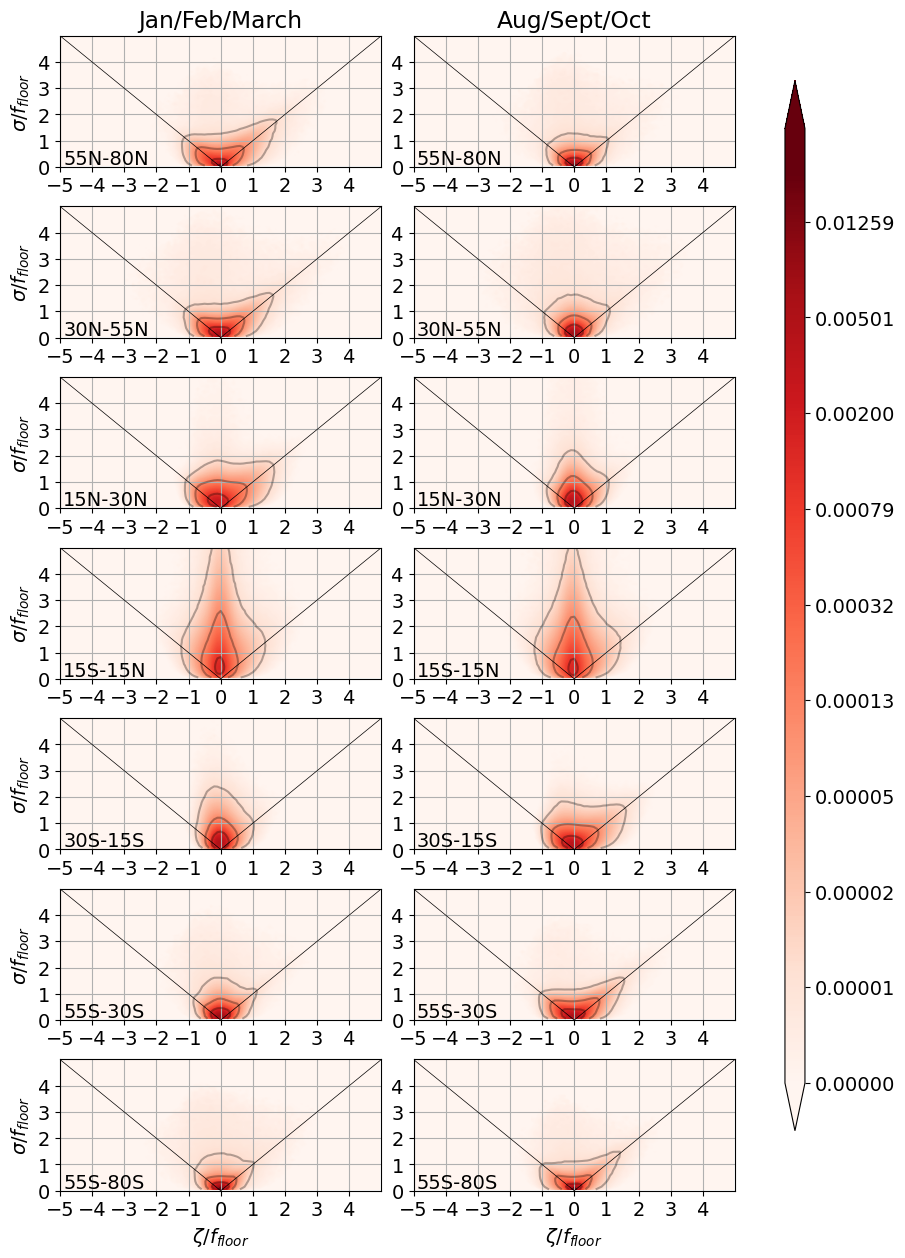

In [28]:
import matplotlib.colors as cols

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10,15))
plt.clf()
plt.subplot(721)

levels = 10**(np.arange(-5.5, -1.5, 0.01))
h_vs_lat1.isel(lat_bins=0).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1.isel(lat_bins=0).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("Jan/Feb/March")
plt.text(-4.9, 0.1, "55N-80N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(722)
h_vs_lat1_aso.isel(lat_bins=0).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=0).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("Aug/Sept/Oct")
plt.text(-4.9, 0.1, "55N-80N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(723)
h_vs_lat1.isel(lat_bins=1).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1.isel(lat_bins=1).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.text(-4.9, 0.1, "30N-55N")
plt.title("")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(724)
h_vs_lat1_aso.isel(lat_bins=1).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=1).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.text(-4.9, 0.1, "30N-55N")
plt.title("")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()


plt.subplot(725)
h_vs_lat1.isel(lat_bins=2).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1.isel(lat_bins=2).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15N-30N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(726)
h_vs_lat1_aso.isel(lat_bins=2).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=2).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15N-30N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()


plt.subplot(727)
h_vs_lat1.isel(lat_bins=3).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1.isel(lat_bins=3).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15S-15N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(728)
h_vs_lat1_aso.isel(lat_bins=3).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=3).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15S-15N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()


plt.subplot(729)
h_vs_lat1.isel(lat_bins=4).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1.isel(lat_bins=4).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "30S-15S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(7,2,10)
h_vs_lat1_aso.isel(lat_bins=4).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=4).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "30S-15S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()


plt.subplot(7,2,11)
h_vs_lat1.isel(lat_bins=5).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1.isel(lat_bins=5).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-30S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(7,2,12)
h_vs_lat1_aso.isel(lat_bins=5).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=5).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-30S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(7,2,13)
h_vs_lat1.isel(lat_bins=6).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1.isel(lat_bins=6).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-80S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()
plt.xlabel('$\zeta/f_{floor}$')

plt.subplot(7,2,14)
cs = h_vs_lat1_aso.isel(lat_bins=6).plot.contourf(x='vort_bin', vmax=0.02,norm=cols.SymLogNorm(1e-7), cmap='Reds',
                    vmin=10**-5.5,levels=levels,extend='both',add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=6).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-80S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()
plt.xlabel('$\zeta/f_{floor}$')

fig = plt.gcf()

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cs, cax=cbar_ax)
plt.subplots_adjust(right=0.8, hspace=0.3, wspace=0.1)


plt.savefig('lat_jpdf.png')
plt.show()

In [29]:
hdiv_vs_lat = ((h_vs_lat*h_vs_lat.div_bin).mean('div_bin')[::-1,:,:]).load()
hdiv_vs_lat_aso = ((h_vs_lat_aso*h_vs_lat_aso.div_bin).mean('div_bin')[::-1,:,:]).load()

In [30]:
hdiv_vs_lat2 = hdiv_vs_lat.where(h_vs_lat1>10**-6).load()
hdiv_vs_lat2_aso = hdiv_vs_lat_aso.where(h_vs_lat1_aso>10**-6).load()

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:81: SyntaxWarning: invalid escape sequence '\s'
<>:115: SyntaxWarning: invalid escape sequence '\s'
<>:149: SyntaxWarning: invalid escape sequence '\s'
<>:183: SyntaxWarning: invalid escape sequence '\s'
<>:217: SyntaxWarning: invalid escape sequence '\s'
<>:226: SyntaxWarning: invalid escape sequence '\z'
<>:244: SyntaxWarning: invalid escape sequence '\z'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:81: SyntaxWarning: invalid escape sequence '\s'
<>:115: SyntaxWarning: invalid escape sequence '\s'
<>:149: SyntaxWarning: invalid escape sequence '\s'
<>:183: SyntaxWarning: invalid escape sequence '\s'
<>:217: SyntaxWarning: invalid escape sequence '\s'
<>:226: SyntaxWarning: invalid escape sequence '\z'
<>:244: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_1663/2450509079.py:13: SyntaxWarning: invalid escape se

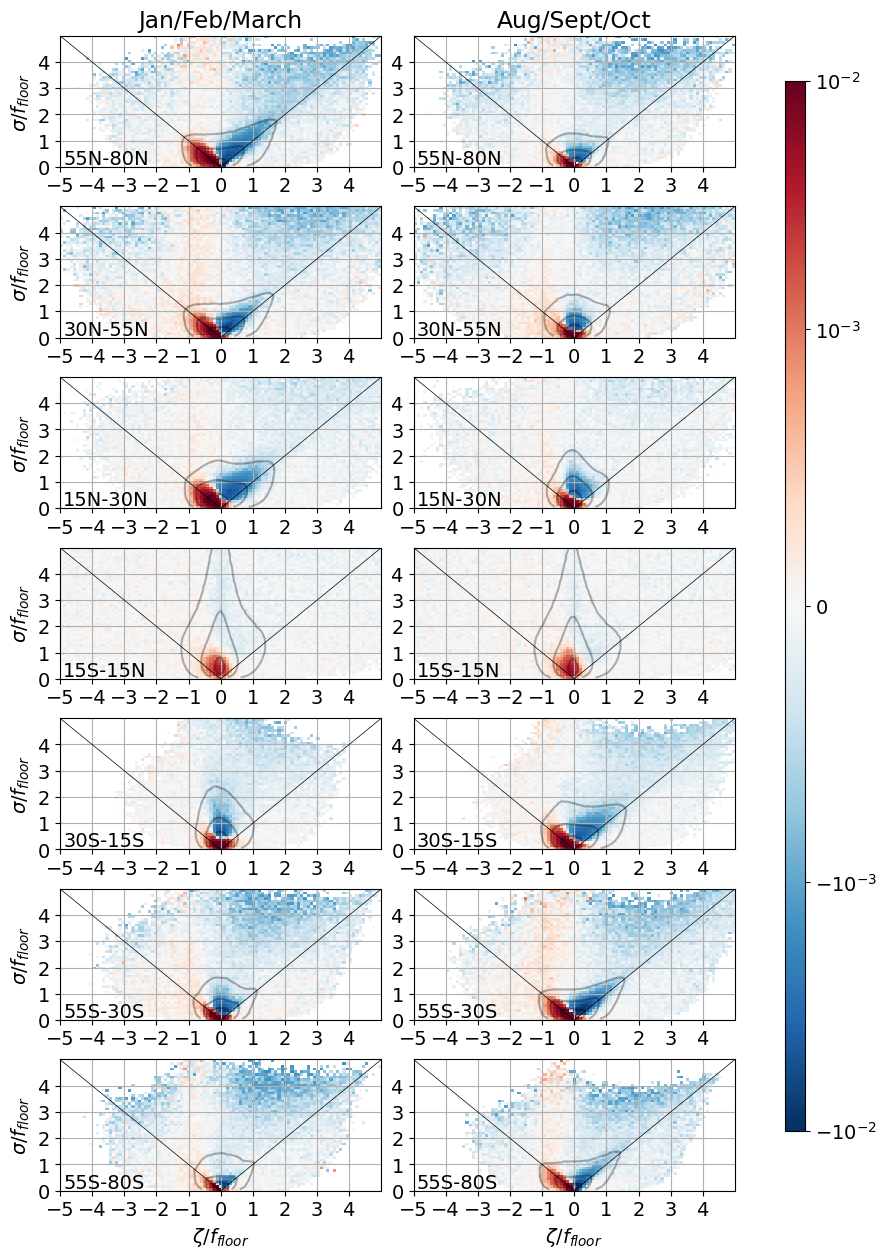

In [31]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,15))
plt.clf()
plt.subplot(721)

levels = 10**(np.arange(-5.5, -1.5, 0.01))
hdiv_vs_lat2.isel(lat_bins=0).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1.isel(lat_bins=0).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("Jan/Feb/March")
plt.text(-4.9, 0.1, "55N-80N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(722)
hdiv_vs_lat2_aso.isel(lat_bins=0).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=0).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("Aug/Sept/Oct")
plt.text(-4.9, 0.1, "55N-80N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(723)
hdiv_vs_lat2.isel(lat_bins=1).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1.isel(lat_bins=1).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.text(-4.9, 0.1, "30N-55N")
plt.title("")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(724)
hdiv_vs_lat2_aso.isel(lat_bins=1).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=1).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.text(-4.9, 0.1, "30N-55N")
plt.title("")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(725)
hdiv_vs_lat2.isel(lat_bins=2).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1.isel(lat_bins=2).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15N-30N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(726)
hdiv_vs_lat2_aso.isel(lat_bins=2).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=2).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15N-30N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(727)
hdiv_vs_lat2.isel(lat_bins=3).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1.isel(lat_bins=3).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15S-15N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(728)
hdiv_vs_lat2_aso.isel(lat_bins=3).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=3).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "15S-15N")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(729)
hdiv_vs_lat2.isel(lat_bins=4).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1.isel(lat_bins=4).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "30S-15S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(7,2,10)
hdiv_vs_lat2_aso.isel(lat_bins=4).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=4).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "30S-15S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(7,2,11)
hdiv_vs_lat2.isel(lat_bins=5).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1.isel(lat_bins=5).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-30S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(7,2,12)
hdiv_vs_lat2_aso.isel(lat_bins=5).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=5).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-30S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()

plt.subplot(7,2,13)
hdiv_vs_lat2.isel(lat_bins=6).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1.isel(lat_bins=6).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('$\sigma/f_{floor}$')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-80S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()
plt.xlabel('$\zeta/f_{floor}$')

plt.subplot(7,2,14)
cs = hdiv_vs_lat2_aso.isel(lat_bins=6).plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
h_vs_lat1_aso.isel(lat_bins=6).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
plt.xlim(-5,5)
plt.ylim(0,5)
plt.ylabel('')#
plt.xlabel('')
plt.title("")
plt.text(-4.9, 0.1, "55S-80S")
x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.grid()
plt.xlabel('$\zeta/f_{floor}$')

fig = plt.gcf()

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cs, cax=cbar_ax)
plt.subplots_adjust(right=0.8, hspace=0.3, wspace=0.1)


plt.savefig('lat_divjpdf.png')
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\z'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_170/4145407666.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma/f_{floor}$')#
/tmp/ipykernel_170/4145407666.py:28: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_170/4145407666.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, title in zip(g.axes.flat, titles):
/tmp/ipykernel_170/4145407666.py:31: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = g.axes[0][0].collections[0]


<Figure size 640x480 with 0 Axes>

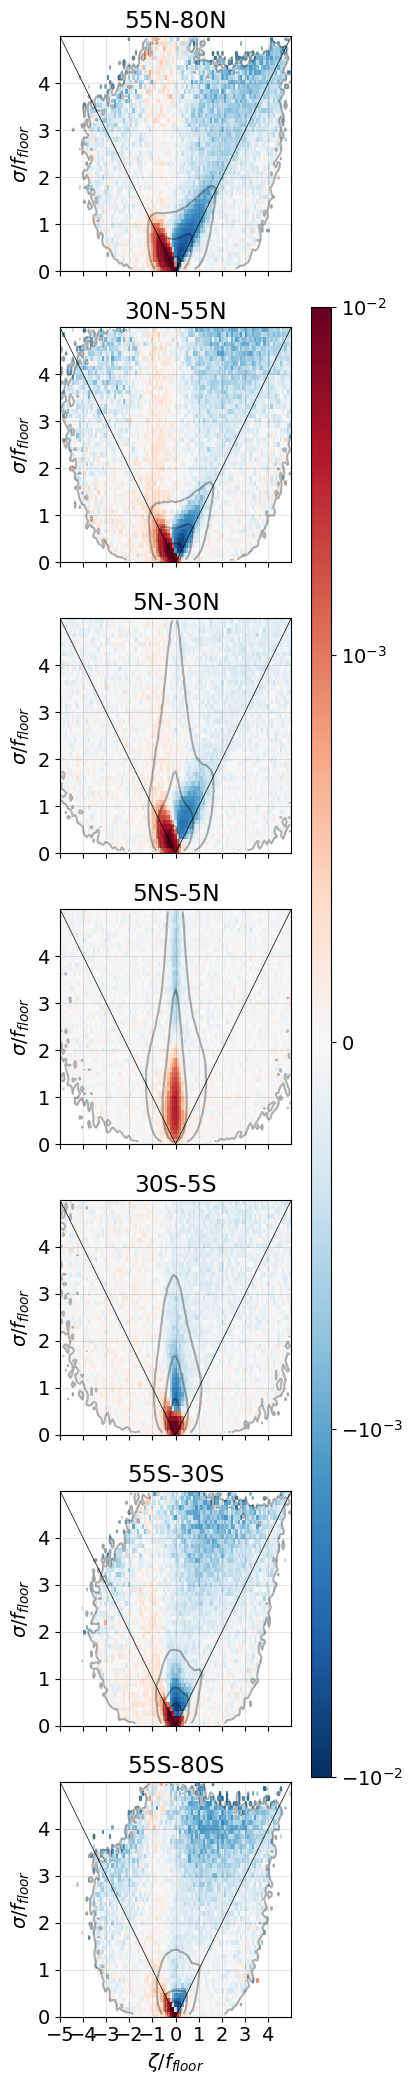

In [62]:
plt.clf()

levels = 10**(np.arange(-5.5, -1.5, 0.1))
g = hdiv_vs_lat2.plot(x='vort_bin', col='lat_bins', col_wrap=1, vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
#h_vort_strain_vs_lat.plot.contour(x='vort_bin', col='lat_bins', col_wrap=1, levels=levels)


n=0
titles = ["55N-80N", "30N-55N", "5N-30N", "5NS-5N", "30S-5S", "55S-30S", "55S-80S"]
for ax, title in zip(g.axes.flat, titles):
    h_vs_lat1.isel(lat_bins=n).plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5, 1e-6], colors='k', alpha=.3,ax = ax)
    ax.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
    ax.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
    ax.set_ylabel('$\sigma/f_{floor}$')#
    ax.set_xlabel('')
    x_ticks = np.arange(-5, 5)
    y_ticks = np.arange(0, 5)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    plt.rc('grid', color='black', alpha=.1)
    ax.grid()
    ax.set_xlim(-5,5)
    ax.set_ylim(0,5)
    
    n=n+1
    ax.set_title(title)

plt.xlabel('$\zeta/f_{floor}$')

fig = plt.gcf()
mappable = g.axes[0][0].collections[0]
cbar_ax = fig.add_axes([0.8, 0.15, 0.05, 0.7])
fig.colorbar(mappable, cax=cbar_ax)
plt.subplots_adjust(right=0.75)

#plt.title('Jan/Feb/Mar Mean divergence')
plt.savefig('JFM_divjpdf.png')

plt.show()

# ASO

In [63]:
h_vs_lat_aso = hist_ds['histogram_vort_strain_div'].groupby_bins('lat', lat_bin_edges).mean(dim='region').roll(time=5,roll_coords=True).isel(time=slice(0,10)).mean('time')#.isel(time=0)
h_vs_lat_aso

<xarray.DataArray 'histogram_vort_strain_div' (lat_bins: 7, vort_bin: 99,
                                               strain_bin: 49, div_bin: 99)> Size: 27MB
dask.array<mean_agg-aggregate, shape=(7, 99, 49, 99), dtype=float64, chunksize=(1, 99, 49, 99), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949
  * vort_bin    (vort_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * lat_bins    (lat_bins) object 56B (-80, -55] (-55, -30] ... (55, 80]

In [64]:
h_vort_strain_vs_lat_aso = h_vs_lat_aso.pdf.marginalize('div_bin')
h_vort_strain_vs_lat_aso

<xarray.DataArray (lat_bins: 7, vort_bin: 99, strain_bin: 49)> Size: 272kB
dask.array<mul, shape=(7, 99, 49), dtype=float64, chunksize=(1, 99, 49), chunktype=numpy.ndarray>
Coordinates:
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949
  * vort_bin    (vort_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * lat_bins    (lat_bins) object 56B (-80, -55] (-55, -30] ... (55, 80]
    div_bin     float64 8B -4.848

In [67]:
h_vs_lat1_aso = h_vort_strain_vs_lat_aso[::-1,:,:]

In [68]:
g=h_vs_lat1_aso.plot(x='vort_bin', col='lat_bins', col_wrap=1, vmax=1e2, norm=mpl.colors.SymLogNorm(5e-3), cmap='Reds',add_colorbar=False)
plt.xlabel('$\zeta/f_{floor}$')


titles = ["55N-80N", "30N-55N", "5N-30N", "5NS-5N", "30S-5S", "55S-30S", "55S-80S"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    ax.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
    ax.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
    ax.set_ylabel('$\sigma/f_{floor}$')

fig = plt.gcf()
mappable = g.axes[0][0].collections[0]
cbar_ax = fig.add_axes([0.8, 0.15, 0.05, 0.7])
fig.colorbar(mappable, cax=cbar_ax)
plt.subplots_adjust(right=0.75)

plt.savefig('ASO_jpdf.png')

<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_170/1979949017.py:2: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_170/1979949017.py:10: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma/f_{floor}$')
/tmp/ipykernel_170/1979949017.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, title in zip(g.axes.flat, titles):
/tmp/ipykernel_170/1979949017.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = g.axes[0][0].collections[0]


In [42]:
hdiv_vs_lat = (h_vs_lat*h_vs_lat.div_bin).mean('div_bin')[::-1,:,:].load()

In [43]:
hdiv_vs_lat2 = hdiv_vs_lat.where(h_vs_lat1>2*10**-3).load()

<>:4: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_383/3848682541.py:4: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_383/3848682541.py:11: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma/f_{floor}$')
/tmp/ipykernel_383/3848682541.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, title in zip(g.axes.flat, titles):
/tmp/ipykernel_383/3848682541.py:14: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = g.axes[0][0].collections[0]


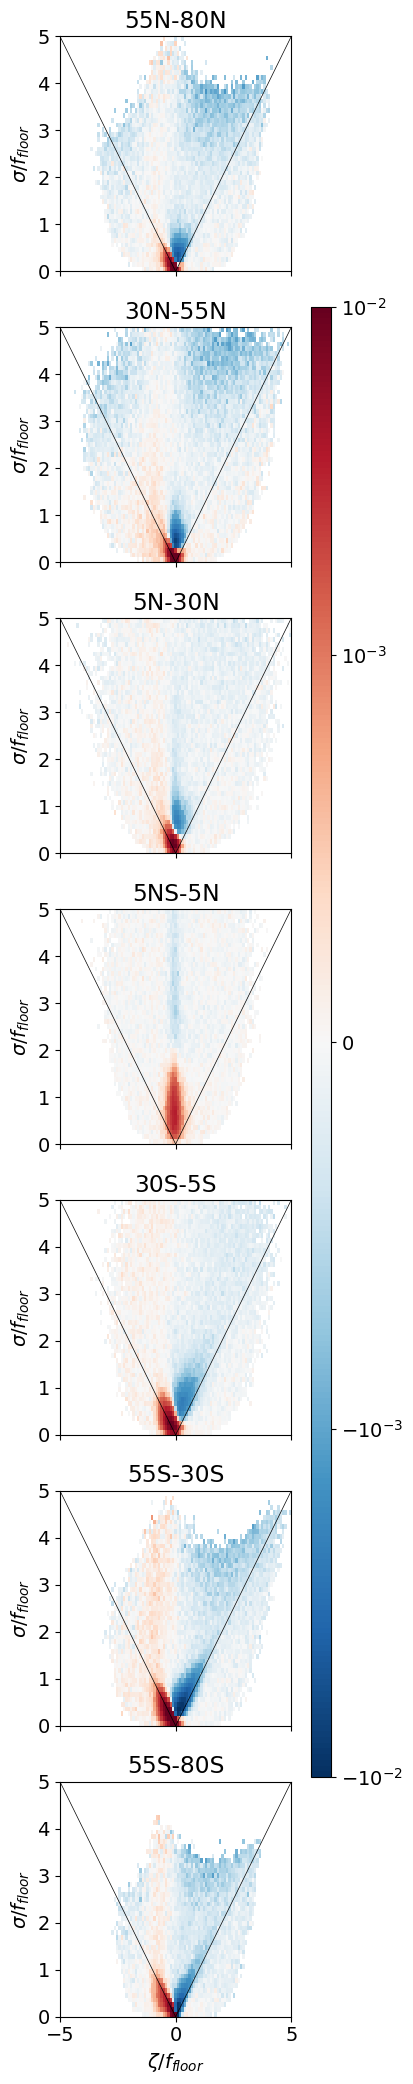

In [44]:
levels = 10**(np.arange(-5.5, -1.5, 0.1))
g = hdiv_vs_lat2.plot(x='vort_bin', col='lat_bins', col_wrap=1, vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
#h_vort_strain_vs_lat.plot.contour(x='vort_bin', col='lat_bins', col_wrap=1, levels=levels)
plt.xlabel('$\zeta/f_{floor}$')

titles = ["55N-80N", "30N-55N", "5N-30N", "5NS-5N", "30S-5S", "55S-30S", "55S-80S"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    ax.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
    ax.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)
    ax.set_ylabel('$\sigma/f_{floor}$')

fig = plt.gcf()
mappable = g.axes[0][0].collections[0]
cbar_ax = fig.add_axes([0.8, 0.15, 0.05, 0.7])
fig.colorbar(mappable, cax=cbar_ax)
plt.subplots_adjust(right=0.75)

plt.savefig('ASO_divjpdf.png')